In [54]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tqdm import tqdm
from PIL import Image
import torch
import torchvision.transforms.v2 as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import seaborn as sns
import polars as pl
import plotly.express as px
import statsmodels as sm
import torch.distributions as dist
import shap
import holoviews as hv
from holoviews import opts
import json
from scripts.images import plot_histogram, compute_mean_variance, compute_kl_divergence, compute_images_similarity
import warnings
from torchvision import models
import torch.nn as nn
%matplotlib inline
warnings.filterwarnings('ignore')
# from alibi_detect.cd import MMDDrift
torch.manual_seed(0)
# set tight layout
plt.rcParams.update({'figure.autolayout': True})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 32

In [56]:
tensor_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [57]:
img_path = "../../data/places/"
dataset = ImageFolder(
    root=img_path,
    transform=tensor_transform
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [58]:
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model.eval();

In [59]:
available_transforms = {
    'rotate': transforms.RandomRotation,
    'flip_horizontal': transforms.RandomHorizontalFlip,
    'brightness': transforms.ColorJitter,
    'contrast': transforms.ColorJitter,
    'saturation': transforms.ColorJitter,
    'hue': transforms.ColorJitter,
    'gaussian_blur': transforms.GaussianBlur,
    'gaussian_noise': transforms.GaussianNoise,
}

In [60]:
def apply_augmentation(name, params):
    if name in available_transforms:
        transform_cls = available_transforms[name]
        transform = transform_cls(**params)
        return transform
    else:
        raise ValueError(f"Augmentation {name} not supported")

In [61]:
def evaluate_augmentations(dataloader, augmentation_name, params):
    metrics = []
    for batch, labels in tqdm(dataloader, desc="Processing batches", total=len(dataloader), leave=True):
        augmented_transform = apply_augmentation(augmentation_name, params)
        augmented_images = augmented_transform(batch)
        # Compute KL divergence
        kl_div = compute_kl_divergence(batch, augmented_images)
        cos_sim = compute_images_similarity(batch, augmented_images, model)
        row_dict = {
            "Augmentation Method": augmentation_name,
            **params,
            "KL Divergence": kl_div,
            "Cosine Similarity": cos_sim,
            # "class": labels[i].item()
        }
        # Store result for each image
        metrics.append(row_dict)
    return metrics

In [65]:
augmentation_methods = [
    ('rotate', [ {'degrees':18*drift_level} for drift_level in np.arange(0.1, 1.1, 0.1)]),  # Rotation with 30 degrees
]

In [66]:
print(augmentation_methods)

[('rotate', [{'degrees': 1.8}, {'degrees': 3.6}, {'degrees': 5.4}, {'degrees': 7.2}, {'degrees': 9.0}, {'degrees': 10.799999999999999}, {'degrees': 12.600000000000001}, {'degrees': 14.4}, {'degrees': 16.2}, {'degrees': 18.0}])]


In [67]:
rotation_results = []
for aug_name, params in augmentation_methods:
    for param in tqdm(params, desc=f"Processing {aug_name}"):
        print("Processing", aug_name, param)
        results = evaluate_augmentations(dataloader, aug_name, param)
        rotation_results.extend(results)

Processing rotate:   0%|          | 0/10 [00:00<?, ?it/s]

Processing rotate {'degrees': 1.8}


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


Processing rotate:  10%|█         | 1/10 [02:48<25:18, 168.73s/it]

95
Processing rotate {'degrees': 3.6}


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


Processing rotate:  10%|█         | 1/10 [04:22<39:19, 262.19s/it]


KeyboardInterrupt: 

In [14]:
rotation_df = pl.DataFrame(rotation_results)
rotation_df.head()


Augmentation Method,degrees,KL Divergence
str,f64,f64
"""rotate""",18.0,0.046229
"""rotate""",18.0,0.07307
"""rotate""",18.0,0.201362
"""rotate""",18.0,0.082979
"""rotate""",18.0,0.059258


In [15]:
rot_grouped_df = rotation_df.group_by(["degrees"]).agg(
    [
        pl.col("KL Divergence").alias("KL Divergence"),
        # pl.col("Cosine Similarity").alias("Cosine Similarity"),
    ]
).sort(["degrees"])
rot_grouped_df

degrees,KL Divergence
f64,list[f64]
18.0,"[0.046229, 0.07307, … 0.264542]"
36.0,"[0.497273, 0.428069, … 0.40331]"
54.0,"[0.489242, 0.437149, … 0.448603]"
72.0,"[0.624848, 0.514687, … 0.684838]"
90.0,"[0.439124, 0.561684, … 0.517952]"
108.0,"[0.420899, 0.456894, … 0.048359]"
126.0,"[0.197548, 0.63591, … 0.069464]"
144.0,"[0.204482, 0.656973, … 0.084999]"
162.0,"[0.5941, 0.509246, … 0.379917]"


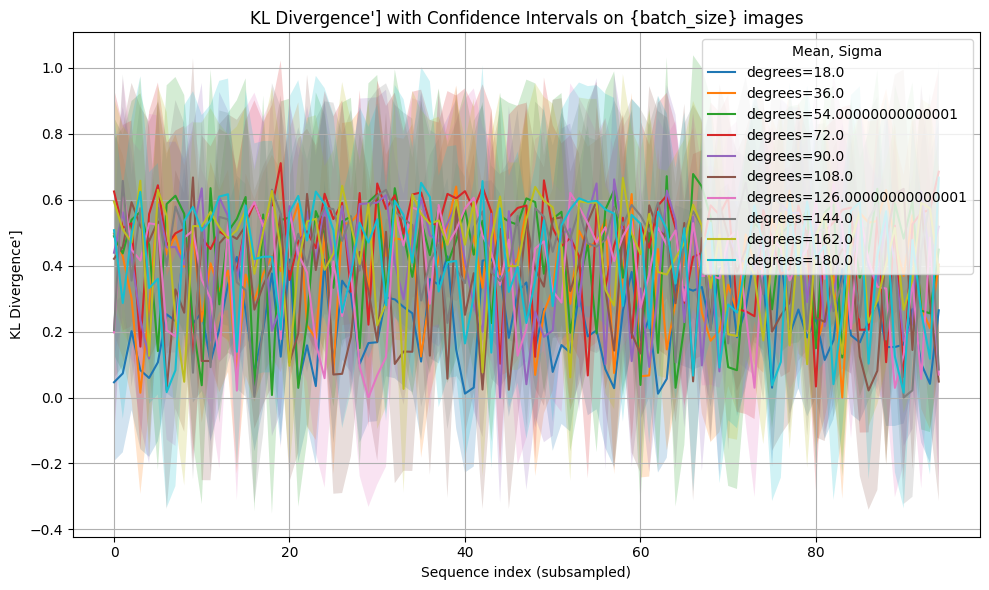

In [16]:

plt.figure(figsize=(10, 6))
for row in rot_grouped_df.iter_rows(named=True):
    # Check condition for specific mean and sigma
    kl_div = row['KL Divergence']
    sequence_index = np.arange(len(kl_div))  # X-axis indices
    
    # Compute confidence intervals (Here we simulate using standard deviation)
    # You can replace this with actual error bounds if available
    ci = 1.96  # 95% confidence interval
    std_dev = np.std(kl_div) * ci  
    lower_bound = np.array(kl_div) - std_dev
    upper_bound = np.array(kl_div) + std_dev
    
    # Plot the KL Divergence'] and fill the area for confidence intervals
    plt.plot(sequence_index, kl_div, label=f"degrees={row['degrees']}")
    plt.fill_between(sequence_index, lower_bound, upper_bound, alpha=0.2)

plt.title("KL Divergence'] with Confidence Intervals on {batch_size} images")
plt.xlabel("Sequence index (subsampled)")
plt.ylabel("KL Divergence']")
plt.legend(title="Mean, Sigma", loc='upper right')
plt.grid(True)
plt.show()

<Axes: xlabel='degrees', ylabel='Cosine Similarity'>

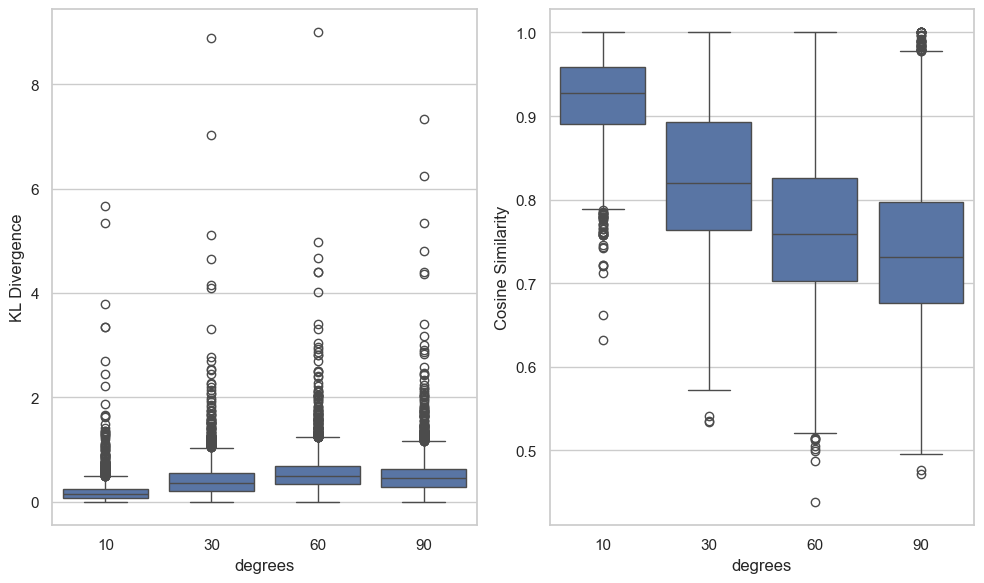

In [60]:
# Evaluate results for each augmentation method
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.boxplot(x="degrees", y="KL Divergence", data=rotation_df, ax=axes[0])
sns.boxplot(x="degrees", y="Cosine Similarity", data=rotation_df, ax=axes[1])

In [171]:
np.arange(0.1, 1.1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [19]:
gaussian_noise_aug = [
    ('gaussian_noise', [{'mean':1*drift_level, 'sigma':5*drift_level} for drift_level in np.arange(0.1, 1.1, 0.1)]),
]

In [20]:
gaussian_results = []
for aug_name, params in gaussian_noise_aug:
    for param in tqdm(params, desc=f"Processing {aug_name}"):
        results = evaluate_augmentations(dataloader, aug_name, param)
        gaussian_results.extend(results)

Processing gaussian_noise: param: {'degrees': 180.0}: 100%|██████████| 10/10 [03:04<00:00, 18.41s/it]


In [21]:
gaussian_noise_df = pl.DataFrame(gaussian_results)
gaussian_noise_df.head()

Augmentation Method,mean,sigma,KL Divergence
str,f64,f64,f64
"""gaussian_noise""",0.1,0.5,1.962471
"""gaussian_noise""",0.1,0.5,1.985275
"""gaussian_noise""",0.1,0.5,1.80295
"""gaussian_noise""",0.1,0.5,1.92363
"""gaussian_noise""",0.1,0.5,1.782481


In [22]:
gn_grouped_df =gaussian_noise_df.group_by(["mean", "sigma"]).agg(
    [
        pl.col("KL Divergence").alias("KL Divergence"),
        # pl.col("Cosine Similarity").alias("Cosine Similarity"),
    ]
).sort(["mean", "sigma"])
gn_grouped_df

mean,sigma,KL Divergence
f64,f64,list[f64]
0.1,0.5,"[1.962471, 1.985275, … 1.997224]"
0.2,1.0,"[1.990738, 1.971672, … 1.97565]"
0.3,1.5,"[2.158478, 2.162322, … 2.116095]"
0.4,2.0,"[2.299428, 2.301259, … 2.335184]"
0.5,2.5,"[2.484246, 2.488006, … 2.475882]"
0.6,3.0,"[2.626762, 2.626382, … 2.630741]"
0.7,3.5,"[2.756304, 2.777141, … 2.73846]"
0.8,4.0,"[2.904176, 2.880663, … 2.874994]"
0.9,4.5,"[2.990883, 2.985398, … 3.010095]"


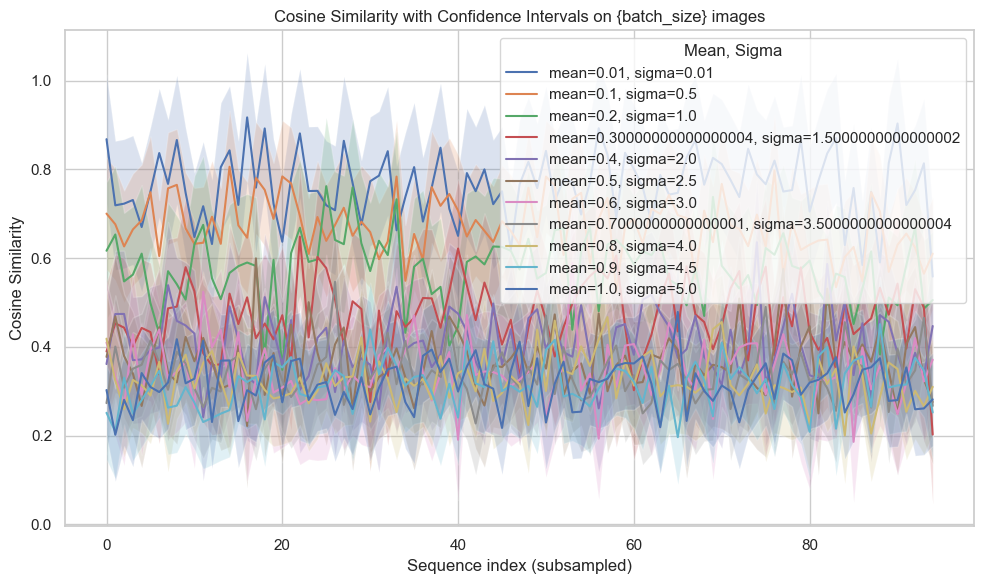

In [189]:
plt.figure(figsize=(10, 6))
for row in gn_grouped_df.iter_rows(named=True):
    # Check condition for specific mean and sigma
    cosine_similarity = row['Cosine Similarity']
    sequence_index = np.arange(len(cosine_similarity))  # X-axis indices
    
    # Compute confidence intervals (Here we simulate using standard deviation)
    # You can replace this with actual error bounds if available
    ci = 1.96  # 95% confidence interval
    std_dev = np.std(cosine_similarity) * ci  
    lower_bound = np.array(cosine_similarity) - std_dev
    upper_bound = np.array(cosine_similarity) + std_dev
    
    # Plot the cosine similarity and fill the area for confidence intervals
    plt.plot(sequence_index, cosine_similarity, label=f"mean={row['mean']}, sigma={row['sigma']}")
    plt.fill_between(sequence_index, lower_bound, upper_bound, alpha=0.2)

plt.title("Cosine Similarity with Confidence Intervals on {batch_size} images")
plt.xlabel("Sequence index (subsampled)")
plt.ylabel("Cosine Similarity")
plt.legend(title="Mean, Sigma")
plt.grid(True)
plt.show()

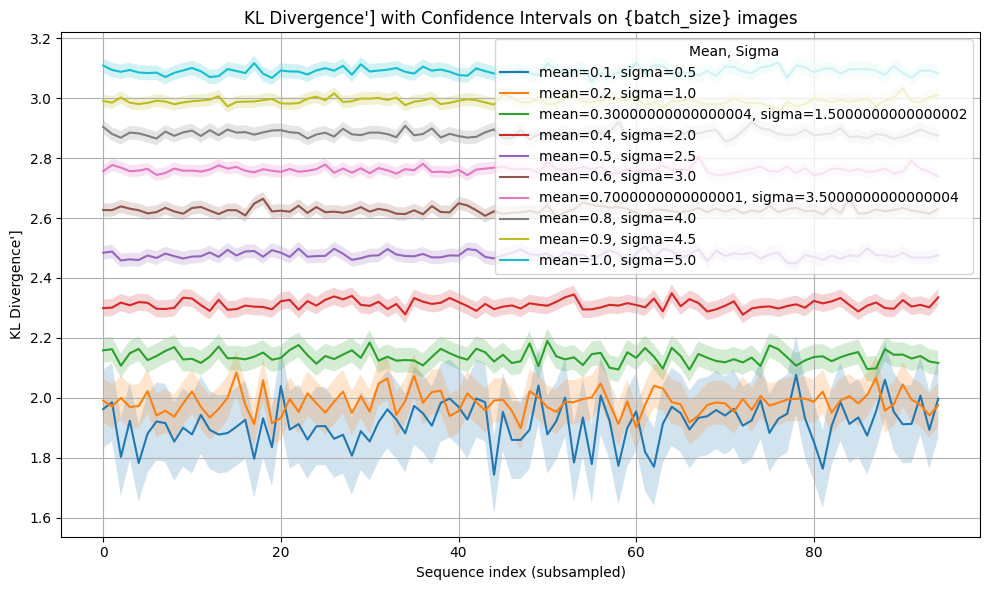

In [23]:
plt.figure(figsize=(10, 6))
for row in gn_grouped_df.iter_rows(named=True):
    # Check condition for specific mean and sigma
    kl_div = row['KL Divergence']
    sequence_index = np.arange(len(kl_div))  # X-axis indices
    
    # Compute confidence intervals (Here we simulate using standard deviation)
    # You can replace this with actual error bounds if available
    ci = 1.96  # 95% confidence interval
    std_dev = np.std(kl_div) * ci  
    lower_bound = np.array(kl_div) - std_dev
    upper_bound = np.array(kl_div) + std_dev
    
    # Plot the KL Divergence'] and fill the area for confidence intervals
    plt.plot(sequence_index, kl_div, label=f"mean={row['mean']}, sigma={row['sigma']}")
    plt.fill_between(sequence_index, lower_bound, upper_bound, alpha=0.2)

plt.title("KL Divergence'] with Confidence Intervals on {batch_size} images")
plt.xlabel("Sequence index (subsampled)")
plt.ylabel("KL Divergence']")
plt.legend(title="Mean, Sigma", loc='upper right')
plt.grid(True)
plt.show()

<Axes: xlabel='sigma', ylabel='Cosine Similarity'>

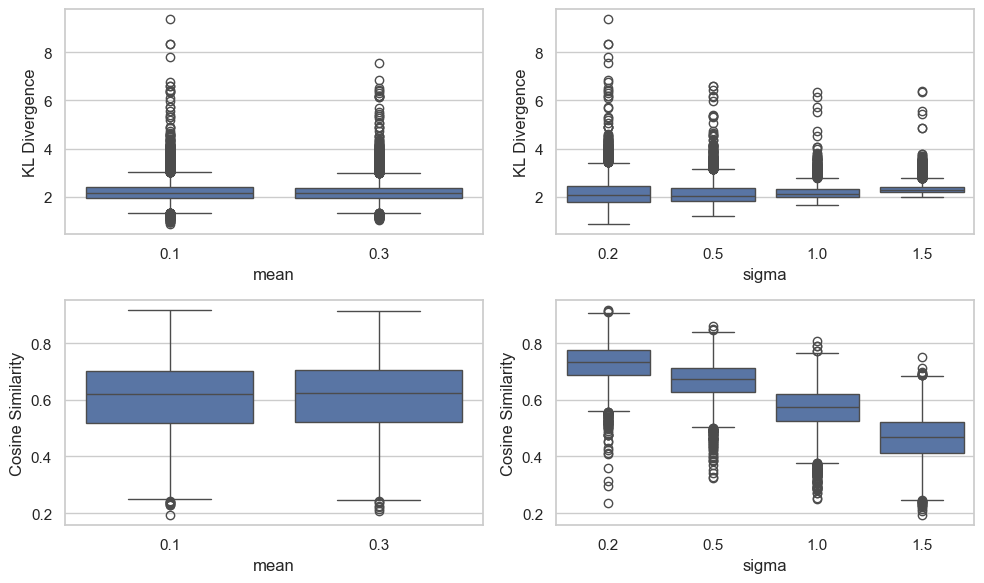

In [100]:
# Evaluate results for each augmentation method
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
sns.boxplot(x="mean", y="KL Divergence", data=gaussian_noise_df, ax=axes[0][0])
sns.boxplot(x="mean", y="Cosine Similarity", data=gaussian_noise_df, ax=axes[1][0])
sns.boxplot(x="sigma", y="KL Divergence", data=gaussian_noise_df, ax=axes[0][1])
sns.boxplot(x="sigma", y="Cosine Similarity", data=gaussian_noise_df, ax=axes[1][1])

In [94]:
gaussian_blur_aug = [
    ('gaussian_blur', [
        {'kernel_size':3, 'sigma':1}, 
        {'kernel_size':3, 'sigma':3},
        {'kernel_size':3, 'sigma':7},  
        {'kernel_size':7, 'sigma':1}, 
        {'kernel_size':7, 'sigma':3},
        {'kernel_size':7, 'sigma':7}, 
    ]),
]

In [95]:
gaussian_blur_results = []
for aug_name, params in gaussian_blur_aug:
    for param in tqdm(params, desc=f"Processing {aug_name}: param: {param}"):
        results = evaluate_augmentations(dataloader, aug_name, param)
        gaussian_blur_results.extend(results)

Processing gaussian_blur: param: {'mean': 0.3, 'sigma': 0.2}: 100%|██████████| 6/6 [1:33:02<00:00, 930.46s/it]   


In [96]:
gaussian_blur_df = pl.DataFrame(gaussian_blur_results)
gaussian_blur_df.head()

Augmentation Method,kernel_size,sigma,KL Divergence,Cosine Similarity,class
str,i64,i64,f64,f64,i64
"""gaussian_blur""",3,1,0.551105,0.947651,0
"""gaussian_blur""",3,1,0.564823,0.964375,0
"""gaussian_blur""",3,1,0.564729,0.952037,0
"""gaussian_blur""",3,1,0.674958,0.947423,0
"""gaussian_blur""",3,1,0.757841,0.94946,1


<Axes: xlabel='sigma', ylabel='Cosine Similarity'>

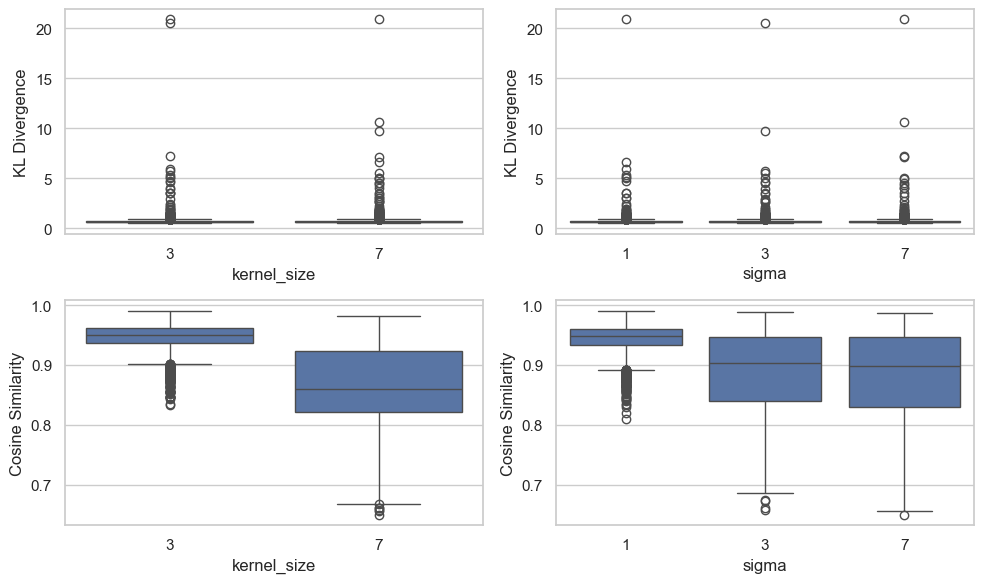

In [97]:
# Evaluate results for each augmentation method
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
sns.boxplot(x="kernel_size", y="KL Divergence", data=gaussian_blur_df, ax=axes[0][0])
sns.boxplot(x="kernel_size", y="Cosine Similarity", data=gaussian_blur_df, ax=axes[1][0])
sns.boxplot(x="sigma", y="KL Divergence", data=gaussian_blur_df, ax=axes[0][1])
sns.boxplot(x="sigma", y="Cosine Similarity", data=gaussian_blur_df, ax=axes[1][1])

In [4]:
denormalize_transform = transforms.Compose([
    transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    ),
])

NameError: name 'mean' is not defined

In [15]:
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(2, 10.0)),
    transforms.GaussianNoise(1, 1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
for i in range(5):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].imshow(denormalize_transform(dataset[i][0]).permute(1, 2, 0))
    axes[1].imshow(denormalize_transform(augment_transform(dataset[i][0])).permute(1, 2, 0))
    plt.show()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plot_histogram(denormalize_transform(dataset[i][0]).permute(1, 2, 0), axes[0], 'Original Image Histogram')
    plot_histogram(denormalize_transform(augment_transform(dataset[i][0])).permute(1, 2, 0), axes[1], 'Transformed Image Histogram')
    plt.show();

Original Mean: tensor([0.4496, 0.6867, 0.9173]), Variance: tensor([1.0243, 1.3317, 1.5808])
Transformed Mean: tensor([0.2313, 0.7275, 1.1314]), Variance: tensor([3.3644, 3.3099, 3.1944])
KL Divergence between original and transformed image: 0.6902119623986528
Image similarity between original and transformed image: 0.6813870668411255


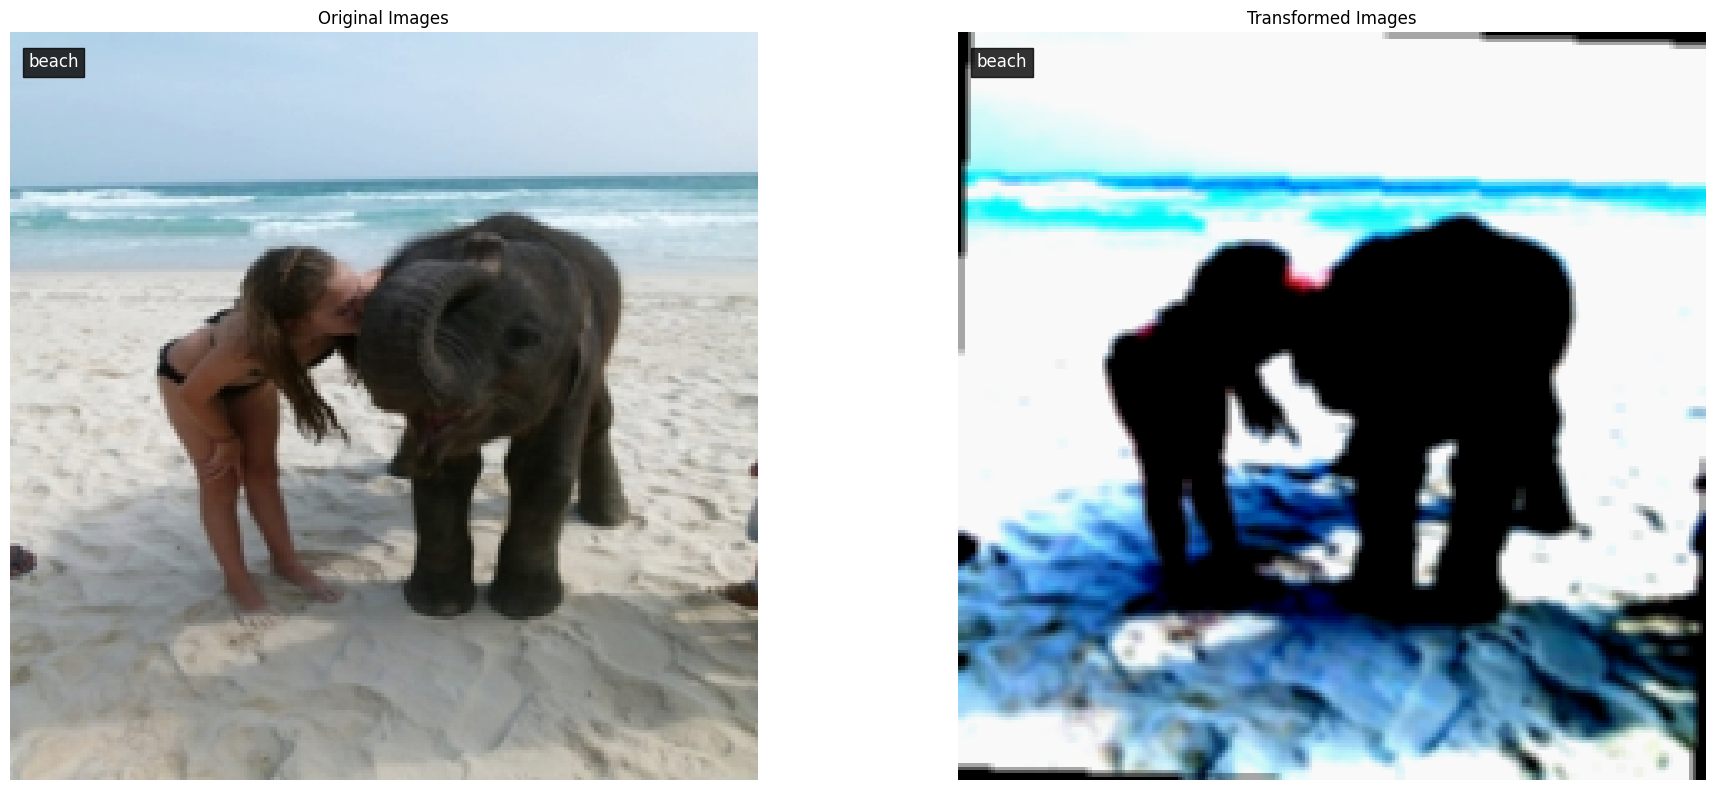

In [26]:

for inputs, labels in dataloader:
    classes = dataset.classes
    np_original = inputs[0].numpy().transpose((1, 2, 0))  # Convert from CHW to HWC for matplotlib
    
    transformed_images = torch.stack([augment_transform(image) for image in inputs])  # Apply transformation manually
    np_transformed = transformed_images[0].numpy().transpose((1, 2, 0))  # Convert from CHW to HWC for matplotlib

    # Evaluate the mean and variance of the images
    orig_mean, orig_variance = compute_mean_variance(inputs[0])
    trans_mean, trans_variance = compute_mean_variance(transformed_images[0])
    print(f"Original Mean: {orig_mean}, Variance: {orig_variance}")
    print(f"Transformed Mean: {trans_mean}, Variance: {trans_variance}")

    # Compute KL divergence
    kl_div = compute_kl_divergence(inputs, transformed_images)
    print(f"KL Divergence between original and transformed image: {kl_div}")
    
    # Compute image similarity
    model = models.resnet18(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
    model.eval()
    
    similarity = compute_images_similarity(inputs[0], transformed_images[0], model)
    print(f"Image similarity between original and transformed image: {similarity}")

    # Denormalize the images for display
    den_or_img = denormalize_transform(inputs)
    den_tr_img = denormalize_transform(transformed_images)
    den_or_img_grid = make_grid(den_or_img)
    den_tr_img_grid = make_grid(den_tr_img)
    den_or_img = den_or_img_grid.numpy().transpose((1, 2, 0))
    den_tr_img = den_tr_img_grid.numpy().transpose((1, 2, 0))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    # Display the image grid without any denormalization
    axes[0].imshow(den_or_img)
    axes[0].axis('off')
    axes[0].set_title('Original Images')

    axes[1].imshow(den_tr_img)
    axes[1].axis('off')
    axes[1].set_title('Transformed Images')
    
    # Add labels for the first few images
    for i in range(1):  # If showing more, adjust this
        axes[0].text(5 + i * 75, 10, classes[labels[i]], color="white", fontsize=12, bbox=dict(facecolor='black', alpha=0.8))
        axes[1].text(5 + i * 75, 10, classes[labels[i]], color="white", fontsize=12, bbox=dict(facecolor='black', alpha=0.8))

    plt.show()  # Show the plot once
    break  # Stop after the first batch
